Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [2]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36


In [3]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [4]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.000192523 0.9997811
0.0 1.0


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [6]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def get_clusters(real_data, generated_data, number_of_bins=25):
    data = np.concatenate((real_data, generated_data))
    
    kmeans = MiniBatchKMeans(number_of_bins)
    clusters = kmeans.fit_predict(data)
    
    real_clusters = clusters[:real_data.shape[0]]
    gen_clusters = clusters[real_data.shape[0]:]
    
    return real_clusters, gen_clusters

def plot_densities(real_clusters, gen_clusters, number_of_bins=25):
    plt.hist(real_clusters, bins=number_of_bins, density=True, label="real",  alpha=0.5)
    plt.hist(gen_clusters, bins=number_of_bins, density=True, label="gen",  alpha=0.5)
    plt.title('Real and generated data distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def bin_counts (real_data, generated_data, number_of_bins=25):
    # binirize real and generated data, plot histogram and found density function
    real_clusters, gen_clusters = get_clusters(real_data, generated_data, number_of_bins)
    
    real_density = np.histogram(real_clusters, bins=number_of_bins, range=(0, number_of_bins),density=True)[0]
    gen_density = np.histogram(gen_clusters, bins=number_of_bins, range=(0, number_of_bins) ,density=True)[0]
    
    return real_density, gen_density

In [7]:
n_objects = min(len(real_data),
                len(gan_data),
                len(vae_data))

real_imgs = real_data.image[np.random.choice(len(real_data), n_objects, replace=False)]
gan_imgs = gan_data.image[np.random.choice(len(gan_data), n_objects, replace=False)]
vae_imgs = vae_data.image[np.random.choice(len(vae_data), n_objects, replace=False)]

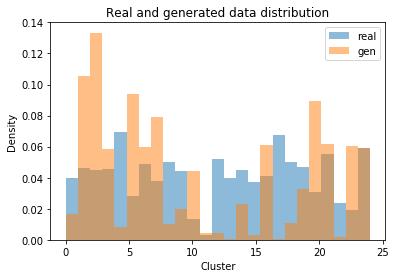

In [8]:
real_clusters, gen_clusters = get_clusters(real_imgs, gan_imgs)
plot_densities(real_clusters, gen_clusters)

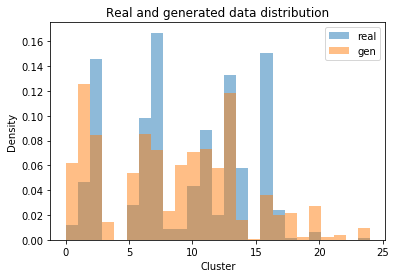

In [9]:
real_clusters, gen_clusters = get_clusters(real_imgs, vae_imgs)
plot_densities(real_clusters, gen_clusters)

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [10]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    
    for l in np.tan(angles):
        alpha_vec.append(np.sum(np.minimum(real_density * l, gen_density)))
        beta_vec.append(np.sum(np.minimum(real_density, gen_density / l)))
        
    alpha_vec = np.array(alpha_vec)
    beta_vec = np.array(beta_vec)
    
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [11]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [count_alpha_beta(reals, gens) for i in range(repeat_number)]
    vectors = np.array(vectors).mean(axis=0)
    print (vectors.shape)
    return vectors

## 2. Apply it##

In [12]:
a, b = bin_counts(real_imgs, vae_imgs)
c, d = bin_counts(real_imgs, gan_imgs)

## 3. Make vectors for plot and plot ##

In [13]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

(2, 1000)
(2, 1000)


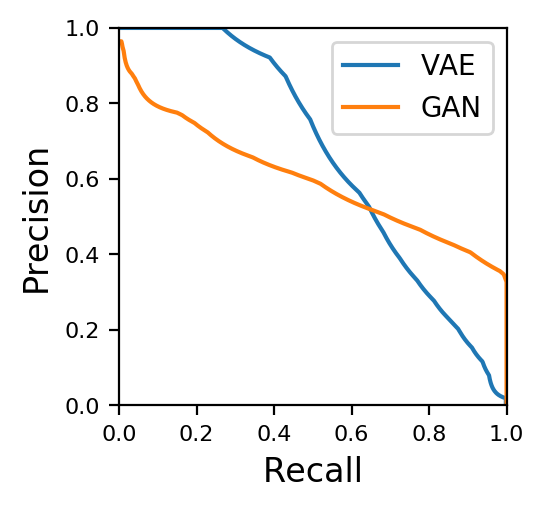

In [14]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

Seems like area under VAE curve is a bit bigger, but they still look pretty much the same. GAN is more appropriate for improving precision maintaining the level of recall, and VAE allows the opposite. Analysing the images generated it can be deduced that VAE generates steady pictures with a small pool of features, they does not differ much. Conversely, GAN generates unique images which, unfortunately, are grainy and contain a lot of artifacts.

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [16]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
